# Import

In [ ]:
import os
import torch
import cv2 as cv
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import Patch
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
%matplotlib inline
# %matplotlib widget
import matplotlib.pyplot as plt
#make plots interactive:

# Prepare Data
This should load all available data and also create some output directories. Feel free to rename variables or add additional directories as you see fit.

In [ ]:
#Inputs
base_path = os.getcwd()
data_path = os.path.join(base_path, f"data")
img_path = os.path.join(data_path, 'images')
depth_path = os.path.join(data_path, 'depths')
test_path = os.path.join(data_path, 'tests')
print(f"The project's root path is '{base_path}'.")
print(f"Reading data from '{data_path}'.")
print(f"Image folder: '{img_path}'.")
print(f"Depth folder: '{depth_path}'.")

#Outputs
out_path = os.path.join(base_path, 'output')
ply_path = os.path.join(out_path, 'point_cloud')
os.makedirs(out_path, exist_ok=True)
os.makedirs(ply_path, exist_ok=True)
print(f"\nCreating directory '{out_path}'.")
print(f"Creating directory '{ply_path}'.")

#Load Data
camera_calibration = np.load(os.path.join(data_path, 'camera_calibration.npy'), allow_pickle=True)
camera_calibration = camera_calibration.item()#get dictionary from numpy array struct
given_features = np.load(os.path.join(data_path, 'given_features.npy'), allow_pickle=True)
camera_movement = np.load(os.path.join(data_path, 'camera_movement.npy'), allow_pickle=True)

print(f"\nCamera Calibration:")
for entry in camera_calibration.items():
    print(f"  {entry[0]}: {entry[1]}")
print(f"Camera Movement: {camera_movement.shape}")#[Cameras-1, 4, 4]
print(f"2D Features (Unsorted): {given_features.shape}")#[Camera_idx, Feature_idx, 2]

# Provided Utility Functions
These functions are provided to reduce the complexity of some steps you might encounter. They were involved in the creation of the given samples. However, you do not have to use them and can use other means of achieving the same results.

In [3]:
def sample_image(numpy_image, numpy_sample_grid):
    '''
    This function samples a target image from a source image (numpy_image) based on specified pixel coordinates (numpy_sample_grid).
    Inputs:
        numpy_image: of shape=[H, W, C]. H is the height, W is the width, and C is the color channel of the source image from which color values will be sampled.
        numpy_sample_grid: of shape=[H, W, UV]. H is the height and W is the width of the target image that will be sampled. UV are the pixel locations in the source image from which to sample color values.
    Outputs:
        sampled_image: of shape=[H, W, C]. H is the height, W is the width, and C is the color channel of the target image that was sampled.
    '''
    height, width, _ = numpy_image.shape#[H, W, 3]

    #turn numpy array to torch tensor
    torch_sample_grid = torch.from_numpy(numpy_sample_grid)#[H, W, 2]
    #normalize from range (0, width-1) to (0, 1)
    torch_sample_grid[:, :, 0] = torch_sample_grid[:, :, 0] / (width-1)
    #normalize from range (0, height-1) to (0, 1)
    torch_sample_grid[:, :, 1] = torch_sample_grid[:, :, 1] / (height-1)
    #normalize from range (0, 1) to (-1, 1)
    torch_sample_grid = torch_sample_grid*2 -1

    #transform to necessary shapes
    torch_sample_grid = torch_sample_grid.unsqueeze(0)#[1, H, W, 2]
    torch_image = torch.from_numpy(numpy_image).double().permute(2, 0, 1).unsqueeze(0)#[1, 3, H, W]
    #sample image according to sample grid locations from source image
    sampled_image = torch.nn.functional.grid_sample(torch_image, torch_sample_grid, mode='bilinear', padding_mode='zeros', align_corners=True)
    #transform back to numpy image
    sampled_image = sampled_image.squeeze().permute(1, 2, 0).numpy().astype(np.uint8)#[H, W, 3]
    return sampled_image

def ply_creator(input_3d, rgb_data=None, filename='dummy'):
    ''' Creates a colored point cloud that you can visualise using e.g. Meshlab.
    Inputs:
        input_3d: of shape=[N, 3], each row is the 3D coordinate of each point
        rgb_data(optional): of shape=[N, 3], each row is the rgb color value of each point
        filename: file name for the .ply file to be created 
    '''
    assert (input_3d.ndim==2),"Pass 3d points as NumPointsX3 array "
    pre_text1 = """ply\nformat ascii 1.0"""
    pre_text2 = "element vertex "
    pre_text3 = """property float x\nproperty float y\nproperty float z\nproperty uchar red\nproperty uchar green\nproperty uchar blue\nend_header"""
    # pre_text3 = """property float x\nproperty float y\nproperty float z\nproperty float red\nproperty float green\nproperty float blue\nend_header"""

    pre_text22 = pre_text2 + str(input_3d.shape[0])
    pre_text11 = pre_text1
    pre_text33 = pre_text3
    filename = filename + '.ply'
    fid = open(ply_path+'/'+filename, 'w')
    fid.write(pre_text11)
    fid.write('\n')
    fid.write(pre_text22)
    fid.write('\n')
    fid.write(pre_text33)
    fid.write('\n')
    for i in range(input_3d.shape[0]):
        for c in range(3):
            fid.write(str(input_3d[i,c]) + ' ')
        if not rgb_data is None:
            for c in range(3):
                fid.write(str(int(rgb_data[i,c])) + ' ')
        if i!=input_3d.shape[0]:
            fid.write('\n')
    fid.close()
    return filename

In [4]:
height = camera_calibration['image_height']
width = camera_calibration['image_width']
sensor_height = camera_calibration['sensor_width_mm']*height/width
fx = camera_calibration['focal_length_mm']*width/camera_calibration['sensor_width_mm']
fy = camera_calibration['focal_length_mm']*height/sensor_height
intrinsics = [fx, fy, camera_calibration['principal_point'][1], camera_calibration['principal_point'][0]]
K = [[fx, 0, camera_calibration['principal_point'][1]], [0, fy, camera_calibration['principal_point'][0]], [0, 0, 1]]
K = np.array(K)

In [5]:
def map_target_to_source(target_res, K_t, K_s, distortion_coeffs, source_image):
    # Target resolution
    H_t, W_t = target_res
    H_s, W_s, _ = source_image.shape
    
    # Intrinsic parameters
    fx_t, fy_t, cx_t, cy_t = K_t
    fx_s, fy_s, cx_s, cy_s = K_s
    k1, k2, p1, p2, k3 = distortion_coeffs
    
    # Initialize target image
    target_image = np.zeros((H_t, W_t, 2))
    
    # Generate target pixel grid
    for v_t in range(H_t):
        for u_t in range(W_t):
            # Step 1: Target pixel to normalized coordinates
            x_t = (u_t - cx_t) / fx_t
            y_t = (v_t - cy_t) / fy_t

            # Step 2: Apply distortion
            r2 = x_t**2 + y_t**2
            x_d = x_t * (1 + k1*r2 + k2*r2**2 + k3*r2**3) + 2*p1*x_t*y_t + p2*(r2 + 2*x_t**2)
            y_d = y_t * (1 + k1*r2 + k2*r2**2 + k3*r2**3) + p1*(r2 + 2*y_t**2) + 2*p2*x_t*y_t
            
            # Step 3: Convert to source pixel coordinates
            u_s = fx_s * x_d + cx_s
            v_s = fy_s * y_d + cy_s
            
            u_s_int, v_s_int = round(u_s), round(v_s)
            target_image[v_t, u_t] = [u_s_int, v_s_int]
    
    return target_image

In [6]:
images = []
for i in range(9):
    im = cv.cvtColor(cv.imread(img_path+f'/0{i}.png'), cv.COLOR_BGR2RGB)
    grid = map_target_to_source([height, width], intrinsics, intrinsics, camera_calibration['distortion_param'], im)
    target = sample_image(im, grid)
    images.append(target)

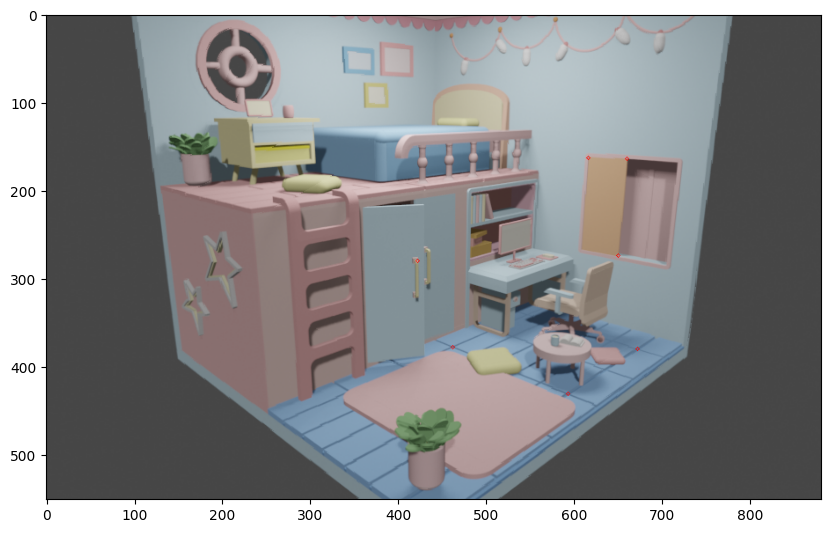

In [7]:
target = images[0].copy()
for x,y in given_features[0]:
    if x != -1 and y != -1:
        target = cv.circle(target, (y,x), radius = 2, color=(255,0,0), thickness=1)
fig = plt.figure(figsize=(10, 10))
axarr = fig.add_subplot(1,1,1)
axarr.imshow(target)

In [8]:
def visualize_camera_poses(transformations):
    fig = plt.figure(figsize=(15,15))
    ax = fig.add_subplot(111, projection='3d')

    # Plot each camera position
    for i, T in enumerate(transformations):
        camera_position = T[:3, 3]
        # Plot camera position
        ax.scatter(camera_position[0], camera_position[1], camera_position[2], label=f"Camera {i}")
        
        # Plot camera orientation axes
        x_axis = camera_position + T[:3, 0] * 0.3  # X-axis in red
        y_axis = camera_position + T[:3, 1] * 0.3  # Y-axis in green
        z_axis = camera_position + T[:3, 2] * 0.3  # Z-axis in blue
        
        ax.plot([camera_position[0], x_axis[0]], [camera_position[1], x_axis[1]], [camera_position[2], x_axis[2]], 'r')
        ax.plot([camera_position[0], y_axis[0]], [camera_position[1], y_axis[1]], [camera_position[2], y_axis[2]], 'g')
        ax.plot([camera_position[0], z_axis[0]], [camera_position[1], z_axis[1]], [camera_position[2], z_axis[2]], 'b')

    # Set plot labels
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.legend()

    return (fig, ax)

In [9]:
#Compute camera to world transformation matrices
camera_to_world = [np.eye(4)]
smt = [0, 0, 0, 1]
for i in range(len(camera_movement)):
    camera_to_world.append(camera_to_world[-1] @ np.linalg.inv(camera_movement[i]))
camera_to_world = np.array(camera_to_world)

In [10]:
def compute_camera_matrices(K, camera_to_world):
    P_matrices = []
    smt = np.array([[1,0,0,0], [0,1,0,0], [0,0,1,0]])
    for el in camera_to_world:
        P_matrices.append(K @ smt @ np.linalg.inv(el))
    return P_matrices
P = compute_camera_matrices(K, camera_to_world)

In [11]:
def compute_fundamental_matrix(K, transformation):
    R = transformation[:3, :3]
    t = transformation[:3, 3]
    t_skew = [
        [0, -t[2], t[1]], 
        [t[2], 0, -t[0]], 
        [-t[1], t[0], 0]
    ]
    t_skew = np.array(t_skew)
    R = np.array(R)
    E = t_skew @ R
    F = np.linalg.inv(K).T@E@np.linalg.inv(K)
    return F

In [12]:
fundamental_matrices = [[np.eye(4) for j in range(len(camera_movement)-i)] for i in range(len(camera_movement))]
for i in range(len(camera_movement)):
    for j in range(i+1):
        for k in range(i,len(camera_movement)):
            fundamental_matrices[j][k-j] = fundamental_matrices[j][k-j] @ np.linalg.inv(camera_movement[i])

for i in range(len(fundamental_matrices)):
    for j in range(len(fundamental_matrices[i])):
        fundamental_matrices[i][j] = compute_fundamental_matrix(K, fundamental_matrices[i][j])

In [13]:
matches2 = [[] for i in range(len(camera_movement))]
for i in range(len(given_features) - 1):
    for j in range(len(given_features) - 1 - i):
        F = fundamental_matrices[i][j]
        img1_points = given_features[j+i+1]
        img2_points = given_features[i]
        curr_match = [-1 for i in range(len(img1_points))]
        for idx, pt1 in enumerate(img1_points):
            if np.all(pt1 == -1):
                continue  # Skip invalid points
            
            pt1_h = np.array([pt1[1], pt1[0], 1.0])  # Homogeneous
            epipolar_line = F @ pt1_h
            a, b, c = epipolar_line
            
            # Find the closest point in img2 to the epipolar line
            min_dist = float('inf')
            best_match = -1
            for jdx, pt2 in enumerate(img2_points):
                if np.all(pt2 == -1):
                    continue  # Skip invalid points
                
                pt2_h = np.array([pt2[1], pt2[0], 1.0])
                dist = abs(a * pt2_h[0] + b * pt2_h[1] + c) / np.sqrt(a**2 + b**2)
                if dist < min_dist:
                    min_dist = dist
                    best_match = jdx
            if curr_match[best_match] == -1 or curr_match[best_match][1] > min_dist:
                curr_match[best_match] = (idx, min_dist)
        match = [-1 for i in range(len(img1_points))]
        for best_m in range(len(curr_match)):
            if curr_match[best_m] != -1 and curr_match[best_m][1] <= 2:
                match[curr_match[best_m][0]] = best_m
        matches2[i].append(match)

In [14]:
points_zero_im = [[[P[0]], [given_features[0][i]]] for i in range(len(given_features[0]))]
for i in range(len(matches2[0])):
    for j in range(len(matches2[0][i])):
        if matches2[0][i][j] != -1:
            points_zero_im[matches2[0][i][j]][0].append(P[i+1])
            points_zero_im[matches2[0][i][j]][1].append(given_features[i+1][j])

In [15]:
def triangulate_point(Ps, xs):
    A = np.zeros((2*len(Ps), 4))
    for i in range(len(Ps)):
        A[i*2] = xs[i][1] * Ps[i][2].T - Ps[i][0].T
        A[i*2+1] = xs[i][0] * Ps[i][2].T - Ps[i][1].T

    _, _, Vt = np.linalg.svd(A)
    X = Vt[-1]

    X /= X[3]
    return X[:3]

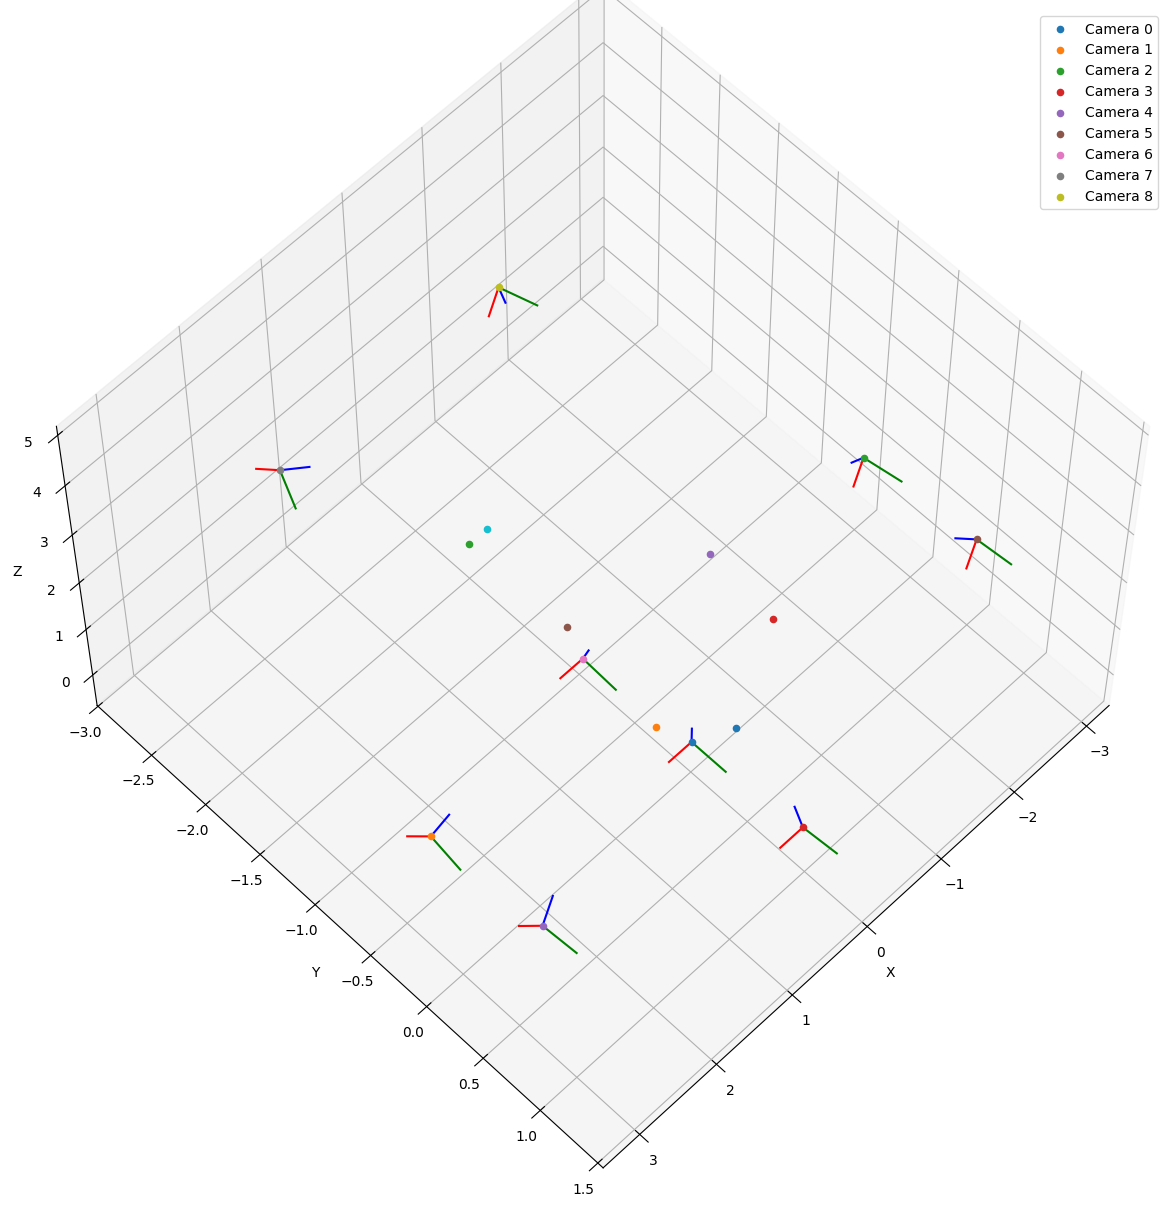

In [16]:
fig, ax = visualize_camera_poses(camera_to_world)
xs = []
for i in range(1):
    for j in range(len(points_zero_im)):
        if len(points_zero_im[j][0]) > 1:
            xs.append(triangulate_point(points_zero_im[j][0], points_zero_im[j][1]))          
            ax.scatter(xs[-1][0], xs[-1][1], xs[-1][2], label=f"point {i}")
ax.view_init(60, 45, 0)
plt.show()
point_cloud = []
point_cloud.extend(xs)

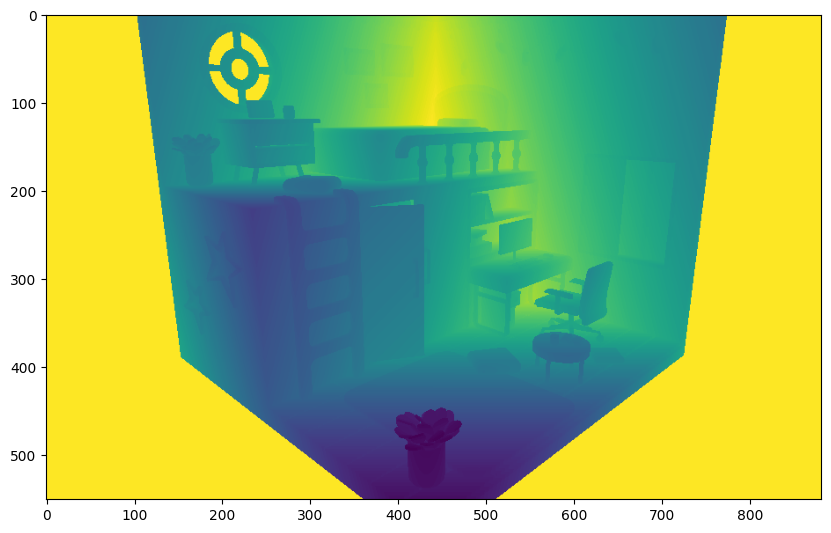

In [17]:
depths = []
for i in range(9):
    depth_image = cv.imread(depth_path+f'/0{i}.png', cv.IMREAD_UNCHANGED)
    depths.append(depth_image)
fig = plt.figure(figsize=(10, 10))
axarr = fig.add_subplot(1,1,1)
axarr.imshow(depths[0])

In [18]:
ds = [[] for i in given_features]
for i in range(len(matches2)):
    for j in range(len(matches2[i])):
        for k in range(len(matches2[i][j])):
            if matches2[i][j][k] != -1:
                x = given_features[i][matches2[i][j][k]]
                x1 = given_features[i+j+1][k]
                point_3d = cv.triangulatePoints(P[i], P[i+j+1], np.array([float(x[1]), float(x[0])]), np.array([float(x1[1]), float(x1[0])]))
                point_3d = point_3d/point_3d[3]
                ds[i].append((x[0], x[1], (np.linalg.inv(camera_to_world[i]) @ (point_3d.T[0]))[2]))
                ds[i+j+1].append((x1[0], x1[1], (np.linalg.inv(camera_to_world[i+j+1]) @ (point_3d.T[0]))[2]))

In [19]:
def reject_outliers(data, m = 2.):
    data = np.array(data)
    d = np.abs(data - np.median(data))
    mdev = np.median(d)
    s = d/mdev if mdev else np.zeros(len(d))
    return data[s<m]

In [20]:
ml = []
for i in range(len(ds)):
    tmp = [zs[2]/depths[i][zs[0]][zs[1]] for zs in ds[i]]
    tmp = reject_outliers(tmp)
    ml.append(np.median(tmp))

In [21]:
for i in range(len(depths)):
    for j in range(len(depths[i])):
        for k in range(len(depths[i][j])):
            if depths[i][j][k] == 255:
                depths[i][j][k] = 0


In [22]:
def depth_to_point_cloud(depth_image, fx, fy, cx, cy, scale, rgb_image, cam_to_w):
    points = []
    rgb_data = []
    height, width = depth_image.shape
    for v in range(height):
        for u in range(width):
            d = depth_image[v, u]
            if d <= 0:
                continue
            
            z = d * scale           
            x = (u - cx) * z / fx
            y = (v - cy) * z / fy
            points.append((cam_to_w @ [x, y, z, 1])[:3])
            rgb_data.append(rgb_image[v, u])
    return points, rgb_data

In [23]:
points_from_depth = []
rgb = []
for i in range(len(depths)):
    tmp_depth, tmp_rgb = depth_to_point_cloud(depths[i], intrinsics[0], intrinsics[1], intrinsics[2], intrinsics[3], 
                                              ml[i], images[i], camera_to_world[i])
    points_from_depth.extend(tmp_depth)
    rgb.extend(tmp_rgb)

In [24]:
points_from_depth = np.array(points_from_depth)
rgb = np.array(rgb)
ply_creator(points_from_depth, rgb, "final_result")

'final_result.ply'